In [ ]:
!unzip LungX-RayImage.zip


Archive:  LungX-RayImage.zip
   creating: Lung_Opacity/
   creating: Normal/
   creating: Viral Pneumonia/
  inflating: Normal/1151.jpg         
  inflating: Normal/1166.jpg         
  inflating: Normal/1048.jpg         
  inflating: Normal/875.jpg          
  inflating: Normal/44.jpg           
  inflating: Normal/1187.jpg         
  inflating: Normal/187.jpg          
  inflating: Normal/404.jpg          
  inflating: Normal/997.jpg          
  inflating: Normal/454.jpg          
  inflating: Normal/1188.jpg         
  inflating: Normal/1165.jpg         
  inflating: Normal/519.jpg          
  inflating: Normal/620.jpg          
  inflating: Normal/713.jpg          
  inflating: Normal/942.jpg          
  inflating: Normal/685.jpg          
  inflating: Normal/1243.jpg         
  inflating: Normal/143.jpg          
  inflating: Normal/742.jpg          
  inflating: Normal/1194.jpg         
  inflating: Normal/1077.jpg         
  inflating: Normal/572.jpg          
  inflating: Normal

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from sklearn.metrics import( cohen_kappa_score,accuracy_score,
                            ConfusionMatrixDisplay,classification_report)
from mpl_toolkits.axes_grid1 import ImageGrid

In [ ]:
Lung_Opacity = [
    r'/content/Lung_Opacity'
]

Normal = [
    r'/content/Normal'

]
Viral_Pneumonia = [
    r'/content/Viral Pneumonia'
]

file_p = []
labels = []
dict_lists = [Normal, Lung_Opacity,Viral_Pneumonia]
class_labels = ['Normal', 'Lung Opacity','Viral Pneumonia']

for i, dir_list in enumerate(dict_lists):
     for j in dir_list:
            list_f = os.listdir(j)
            for name in list_f:
                fpath = os.path.join(j, name)
                file_p.append(fpath)
                labels.append(class_labels[i])


failpath = pd.Series(file_p, name="filepaths")
Labelss = pd.Series(labels, name="labels")
data = pd.concat([failpath, Labelss], axis=1)
df = pd.DataFrame(data)

In [ ]:
df.head()

filepaths  labels
0   /content/Normal/161.jpg  Normal
1   /content/Normal/482.jpg  Normal
2  /content/Normal/1105.jpg  Normal
3   /content/Normal/658.jpg  Normal
4  /content/Normal/1110.jpg  Normal

labels
Normal             1250
Lung Opacity       1125
Viral Pneumonia    1100
Name: count, dtype: int64


<Axes: ylabel='count'>

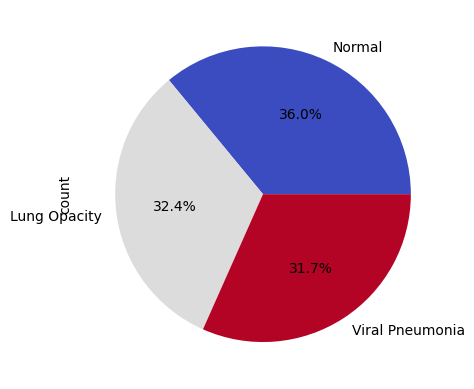

In [ ]:
print(df['labels'].value_counts())
df['labels'].value_counts().plot(kind='pie',autopct='%1.1f%%',cmap = 'coolwarm')

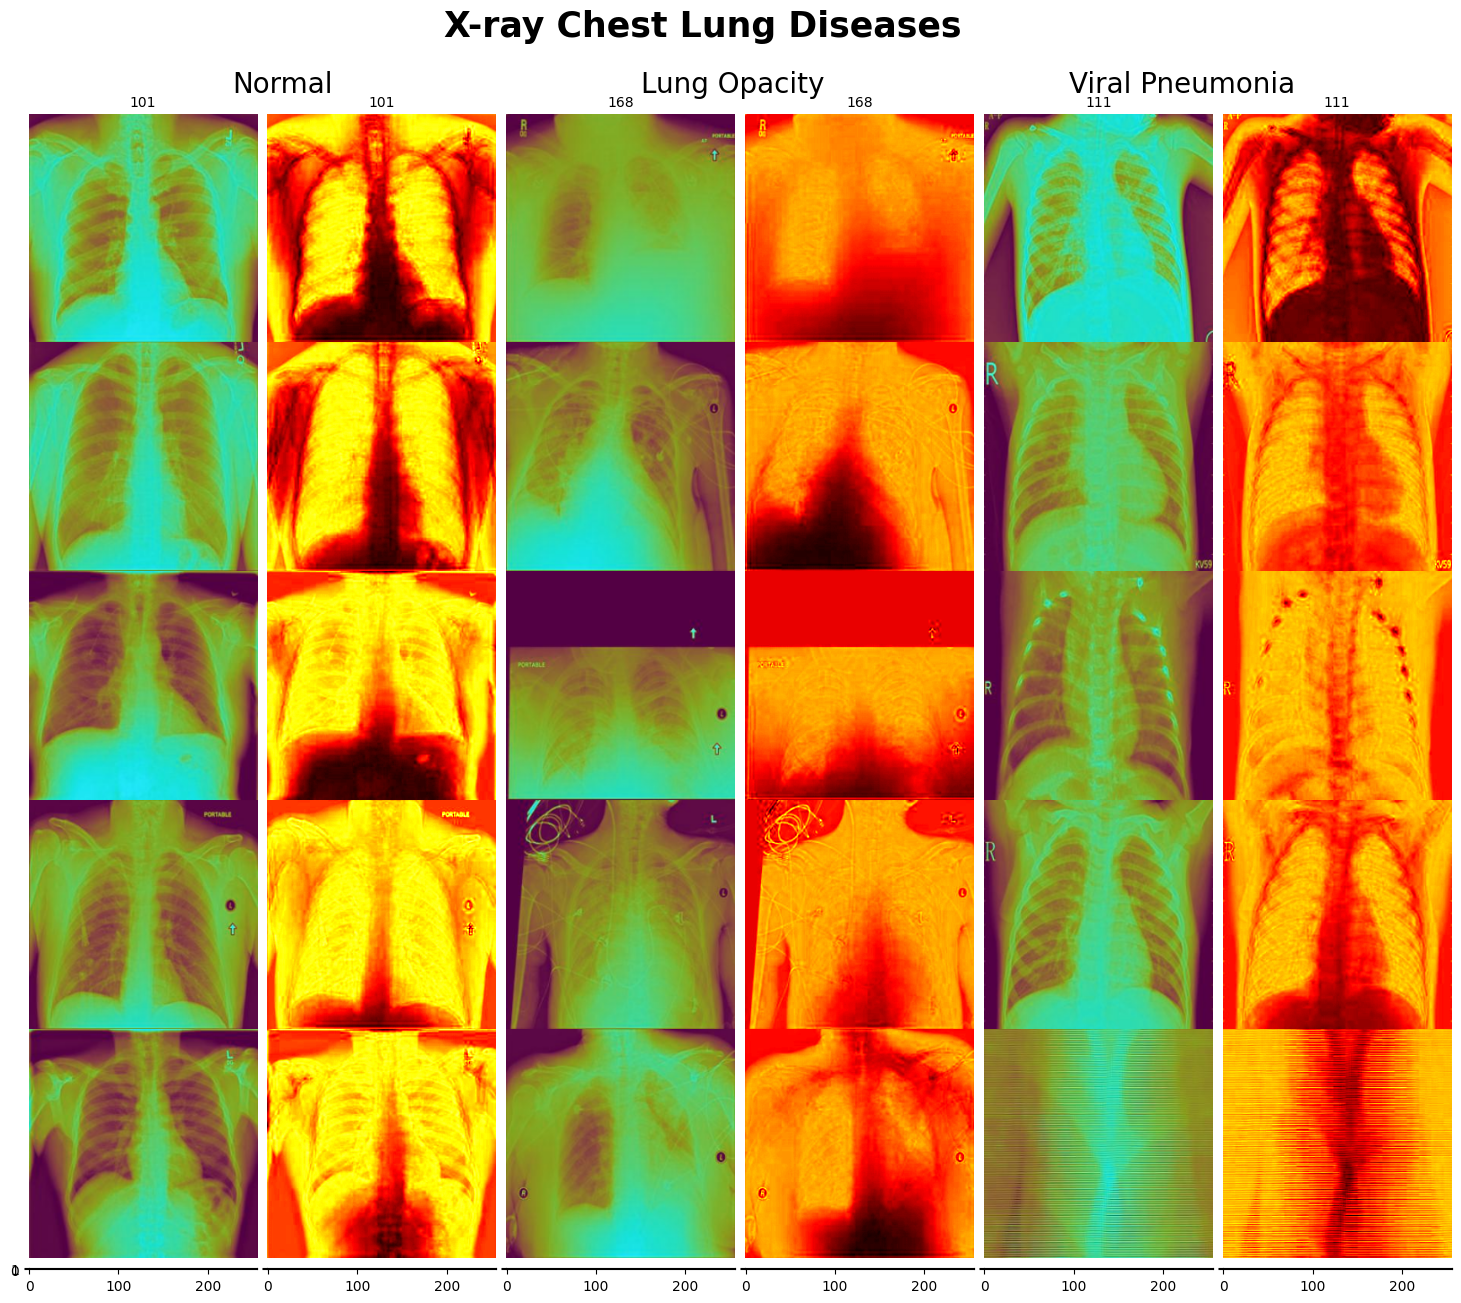

In [ ]:
IMG_SIZE = 256

# Function to generate sample images and arrays
def generate_sample_images(df, label_name):
    sample_df = df.sample(5)
    sample_imgs = []
    for image_path in sample_df["filepaths"].values:
        img = cv2.resize(cv2.imread(image_path), (IMG_SIZE, IMG_SIZE))
        sample_imgs.append(img)
    sample_arr = np.vstack(sample_imgs)
    return sample_arr

# Generate sample image arrays
sample_arr_1 = generate_sample_images(df[df["labels"] == 'Normal' ], "Normal")

sample_arr_2 = generate_sample_images(df[df["labels"] == 'Lung Opacity'], "Lung Opacity")

sample_arr_3 = generate_sample_images(df[df["labels"] == 'Viral Pneumonia'], "Viral Pneumonia)")


# Plot
fig = plt.figure(figsize=(30., 15.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 6),  # creates 3x4 grid of axes (adjust rows for more dataframes)
                 axes_pad=0.1,  # pad between axes in inch.
                 )

# Row 1 (df1)
grid[0].imshow(sample_arr_1)
grid[0].set_title(sample_arr_1[0, 0, 0], fontsize=10)  # Assuming first channel value represents class
grid[0].axis("off")


grid[1].imshow(sample_arr_1[:, :, 0], cmap="hot")  # Assuming first channel for grayscale
grid[1].set_title(sample_arr_1[0, 0, 0], fontsize=10)
grid[1].axis("off")


#  Repeat for remaining dataframes
grid[2].imshow(sample_arr_2)
grid[2].set_title(sample_arr_2[0, 0, 0], fontsize=10)
grid[2].axis("off")

grid[3].imshow(sample_arr_2[:, :, 0], cmap="hot")
grid[3].set_title(sample_arr_2[0, 0, 0], fontsize=10)
grid[3].axis("off")

# Repeat for remaining dataframes
grid[4].imshow(sample_arr_3)
grid[4].set_title(sample_arr_3[0, 0, 0], fontsize=10)
grid[4].axis("off")

grid[5].imshow(sample_arr_3[:, :, 0], cmap="hot")
grid[5].set_title(sample_arr_3[0, 0, 0], fontsize=10)
grid[5].axis("off")

plt.figtext(0.36,0.90,"Normal", va="center", ha="center", size=20)
plt.figtext(0.51,0.90,"Lung Opacity", va="center", ha="center", size=20)
plt.figtext(0.66,0.90,"Viral Pneumonia", va="center", ha="center", size=20)
plt.suptitle("X-ray Chest Lung Diseases",
             y=.95, fontsize=25, weight="bold")

plt.show()

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42,stratify=df.labels)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42,stratify=train_df.labels)
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(2215, 2)
(869, 2)
(391, 2)


In [ ]:
def enhance_image(image):
    image = cv2.addWeighted(image, 1.5, image, -0.5, 0)

    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    image = cv2.filter2D(image, -1, kernel)

    hue = image[:, :, 0]
    saturation = image[:, :, 1]
    value = image[:, :, 2]
    value = np.clip(value * 1.25, 0, 255)

    image[:, :, 2] = value

    return image

In [ ]:
image_gen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda image: enhance_image(image))
train = image_gen.flow_from_dataframe(dataframe= train_df,x_col="filepaths",y_col="labels",
                                      target_size=(256,256),
                                      color_mode='rgb',
                                      class_mode="categorical",
                                      batch_size=32,
                                      shuffle=False
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_df,x_col="filepaths", y_col="labels",
                                     target_size=(256,256),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_df,x_col="filepaths", y_col="labels",
                                    target_size=(256,256),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 2215 validated image filenames belonging to 3 classes.
Found 869 validated image filenames belonging to 3 classes.
Found 391 validated image filenames belonging to 3 classes.


In [ ]:
def show_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen)
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

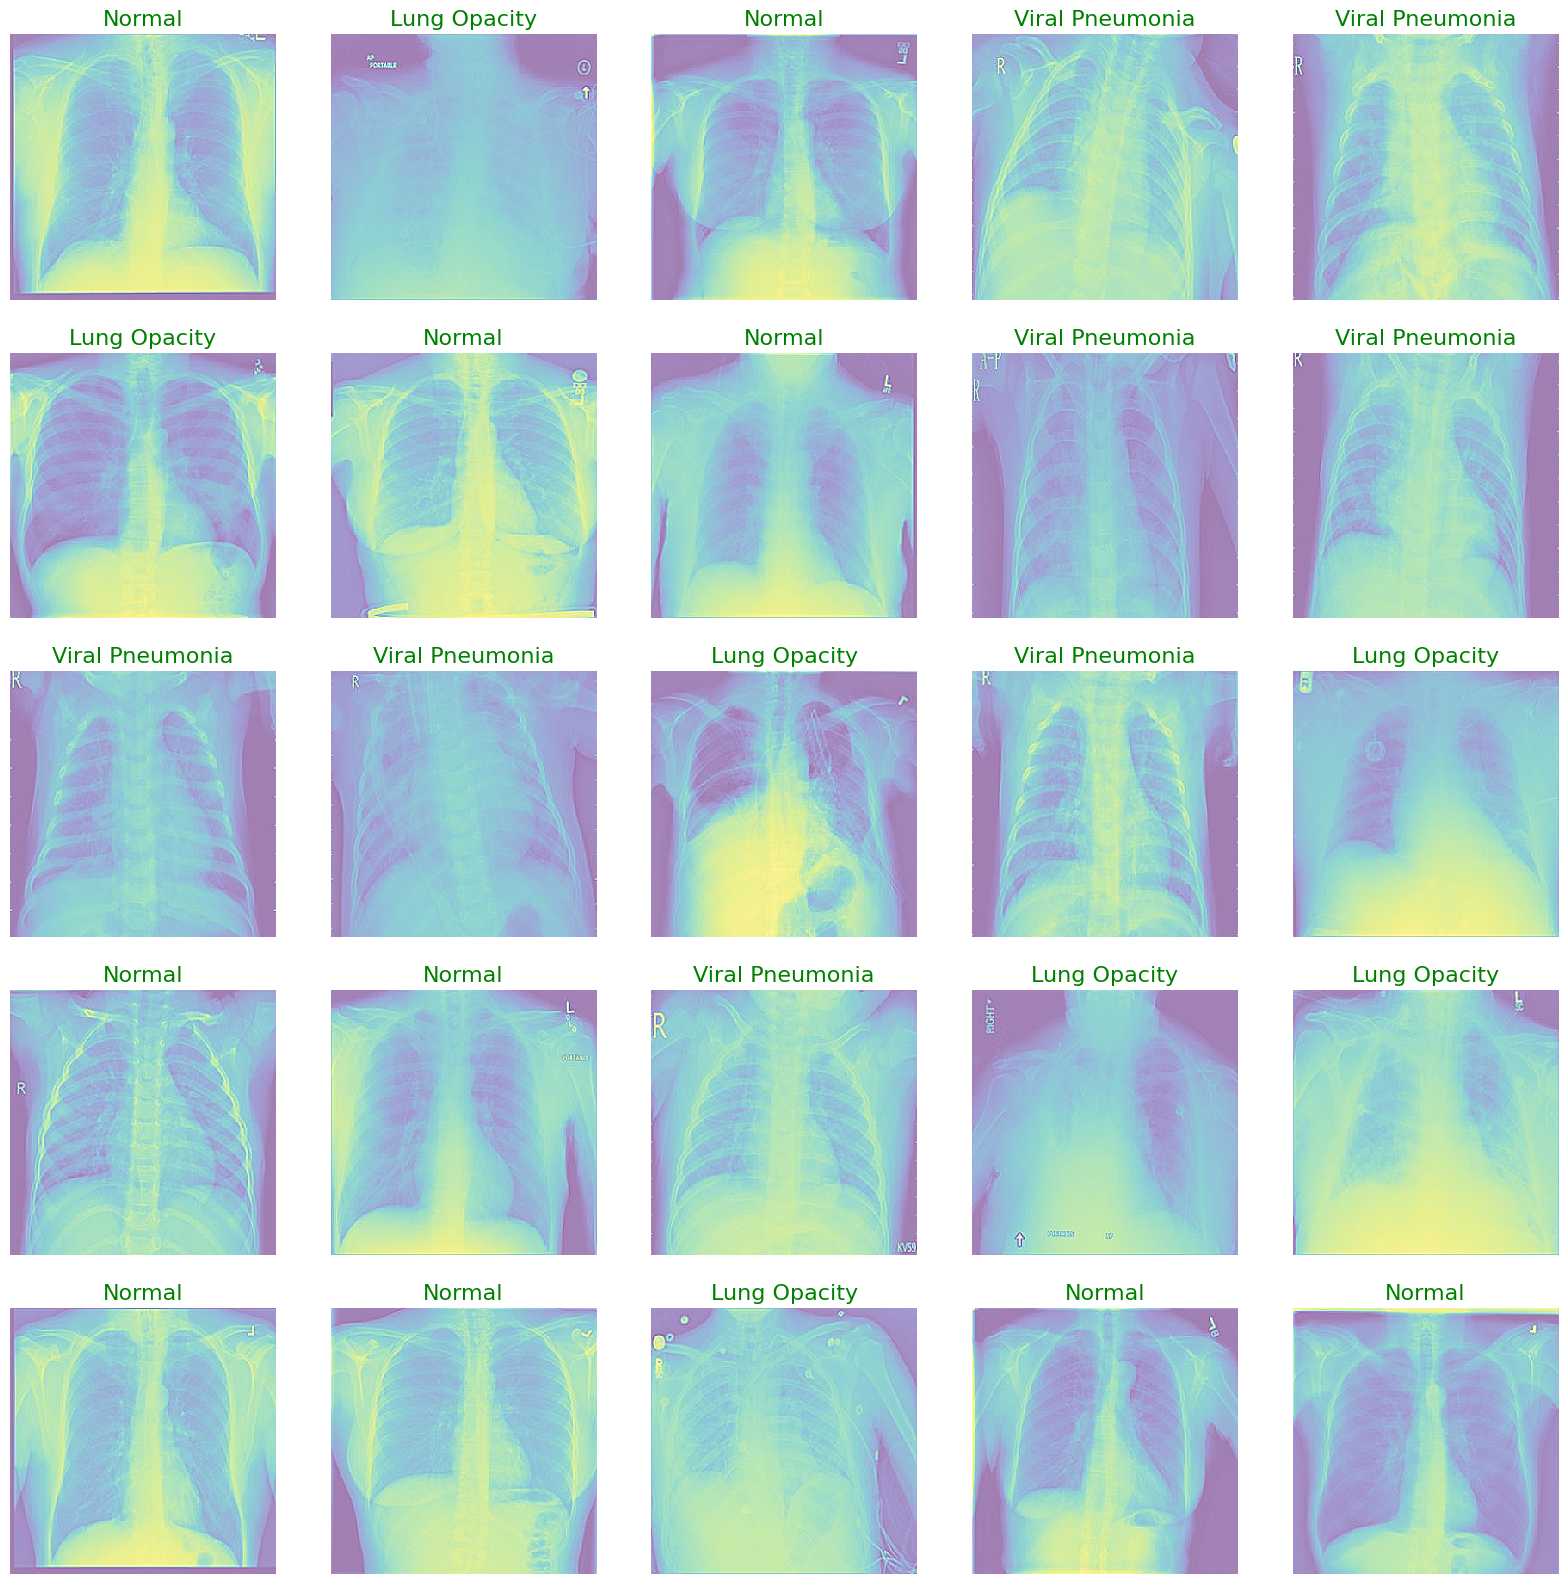

In [ ]:
show_images(train)

In [ ]:
class OneCycleLR(keras.callbacks.Callback):
    """Custom callback for implementing the One-Cycle Learning Rate schedule.

    This callback implements the One-Cycle Learning Rate schedule, dynamically adjusting
    the learning rate during training for potentially faster convergence and better
    generalization. The schedule consists of three phases:

    1. **Ramp Up:** Gradually increases the learning rate from an initial value
       (default: `max_lr` / 10) to the peak learning rate (`max_lr`).
    2. **Sustain:** Maintains the peak learning rate for a certain number of iterations
       (default: half of the total iterations).
    3. **Ramp Down:** Gradually reduces the learning rate to a final value
       (default: `init_lr` / 1000).

    Args:
        itera (int): Total number of training iterations.
        max_lr (float): Peak learning rate to use during the sustain phase.
        init_lr (float, optional): Initial learning rate for the ramp up phase.
            Defaults to `max_lr / 10`.
        final_steps (int, optional): Number of iterations for the ramp down phase.
            Defaults to `itera // 10` (10% of total iterations).
        final_lr (float, optional): Final learning rate to reach at the end of training.
            Defaults to `init_lr / 1000`.
    """

    def __init__(self, itera, max_lr, init_lr=None, final_steps=None, final_lr=None):
        super(OneCycleLR, self).__init__()  # Call the base class constructor
        self.itera = itera
        self.max_lr = max_lr
        self.init_lr = init_lr or max_lr / 10
        self.final_steps = final_steps or int(itera / 10)
        self.h_itera = int((itera - self.final_steps) / 2)  # Half iterations for ramp up
        self.final_lr = final_lr or self.init_lr / 1000
        self.iteraa = 0  # Current iteration counter

    def interpolation(self, y2, y1, x2, x1):
        """Linear interpolation function to calculate learning rate based on phase."""
        return (y2 - y1) / (x2 - x1) * (self.iteraa - x1) + y1

    def on_batch_begin(self, batch, logs):
        """Updates the learning rate at the beginning of each batch based on the current phase."""
        if self.iteraa < self.h_itera:  # Ramp Up phase
            lr = self.interpolation(self.max_lr, self.init_lr, self.h_itera, 0)

        elif self.iteraa < 2 * self.h_itera:  # Sustain phase (constant learning rate)
            lr = self.interpolation(self.init_lr,self.max_lr,2*self.h_itera,self.h_itera)

        else:  # Ramp Down phase
            lr = self.interpolation(self.final_lr, self.init_lr, self.itera, 2 * self.h_itera)

        self.iteraa += 1  # Increment iteration counter
        self.model.optimizer.learning_rate = lr  # Update learning rate

In [ ]:
base_model = keras.applications.EfficientNetB1(weights='imagenet', include_top=False,
                                               input_shape=(256, 256, 3))
x = base_model.output


x = keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1),
                       activation='relu', padding="same")(x)
x = keras.layers.Conv2D(filters=128, kernel_size=(5, 5), strides=(1, 1),
                        activation='relu', padding="same")(x)
x = keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1),
                        activation='relu', padding="same")(x)

x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128, activation='selu')(x)
output = keras.layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs=base_model.input, outputs=output)

In [ ]:
iters = int(train_df.shape[0]/32)*25
one_cycl = OneCycleLR(iters,max_lr=0.00085)
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
tf.debugging.set_log_device_placement(True)


In [ ]:
history2 = model.fit(train, validation_data=val, epochs=25, batch_size=32, callbacks=[one_cycl])

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


70/70 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.7513 - loss: 0.5605 - val_accuracy: 0.3171 - val_loss: 1.1974
Epoch 2/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 267ms/step - accuracy: 0.9483 - loss: 0.1478 - val_accuracy: 0.3171 - val_loss: 1.1724
Epoch 3/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 276ms/step - accuracy: 0.9656 - loss: 0.0917 - val_accuracy: 0.3120 - val_loss: 1.1190
Epoch 4/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 265ms/step - accuracy: 0.9550 - loss: 0.1421 - val_accuracy: 0.3171 - val_loss: 1.7231
Epoch 5/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 272ms/step - accuracy: 0.9779 - loss: 0.0776 - val_accuracy: 0.3197 - val_loss: 3.4053
Epoch 6/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 266ms/step - accuracy: 0.9635 - loss: 0.1268 - val_accuracy: 0.3990 - val_loss: 1.0910
Epoch 7/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 288ms/step - accuracy: 0.9761 - loss: 0.0741 - val_accuracy: 0.5422 - val_loss: 1.8017
Epoch 8/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 268ms/step - accuracy: 0.9760 - loss: 0.0778 - val_accuracy: 0.4757 

In [ ]:
model.evaluate(test)

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 380ms/step - accuracy: 0.9355 - loss: 0.4399


[0.40212270617485046, 0.9367088675498962]

In [ ]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1)

28/28 ━━━━━━━━━━━━━━━━━━━━ 23s 423ms/step


In [ ]:
labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [ ]:
y_test = test_df.labels

Accuracy of test data ||||| 0.9367088607594937
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Kappa Score of test data ||||| 0.9048518679253547
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                 precision    recall  f1-score   support

   Lung Opacity       0.94      0.89      0.92       281
         Normal       0.90      0.93      0.92       313
Viral Pneumonia       0.97      0.99      0.98       275

       accuracy                           0.94       869
      macro avg       0.94      0.94      0.94       869
   weighted avg       0.94      0.94      0.94       869

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


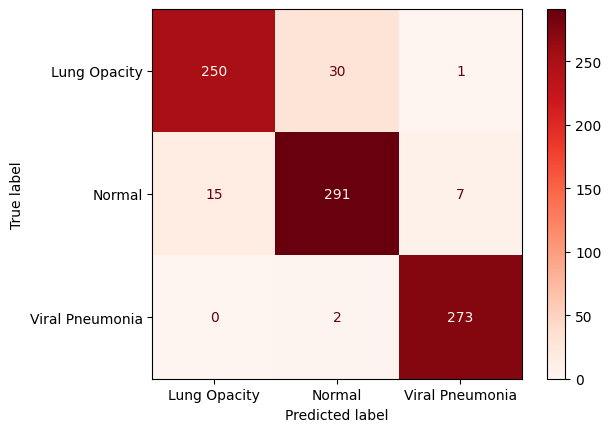

In [ ]:
print(f'Accuracy of test data ||||| {accuracy_score(y_test,pred)}')
print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print(f'Kappa Score of test data ||||| {cohen_kappa_score(y_test,pred)}')
print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print(f'{classification_report(y_test,pred)}')
print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
ConfusionMatrixDisplay.from_predictions(y_test,pred,cmap='Reds')